# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

---

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (i.e. transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [45]:
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import normalize

from xgboost import XGBClassifier

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio

#### Basic Infos:

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print(f'The shape of portfolio data is {portfolio.shape}\n')
print(f'Null values statistics is: \n{portfolio.isnull().sum()}\n')
print(f'There are {portfolio.id.nunique()} unique ids.\n')

The shape of portfolio data is (10, 6)

Null values statistics is: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

There are 10 unique ids.



Text(0.5, 1.0, 'Offer Type Distribution')

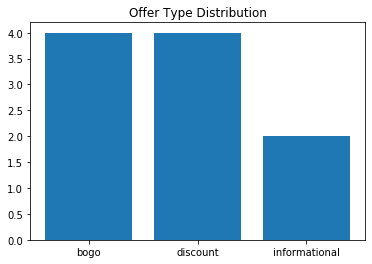

In [5]:
plt.bar(['bogo', 'discount', 'informational'], 
        portfolio.groupby('offer_type').id.count())

plt.title('Offer Type Distribution')

### 2. Profiles

#### Basic Infos:

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**NOTE:** from the `head` we can already see that there are missing values in `income` and `gender`, and `118` seems to represent missing ages.

In [7]:
print(f'The shape of Profile data is {profile.shape}')
print(f'Null values statistics is: \n{profile.isnull().sum()}')
print(f'There are {profile.id.nunique()} unique ids.')

The shape of Profile data is (17000, 5)
Null values statistics is: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
There are 17000 unique ids.


In [8]:
profile_no_age = profile[profile.age==118]
print(f'The shape of the subset is {profile_no_age.shape}\n')
print(f'Null values statistics is: \n{profile_no_age.isnull().sum()}')
profile_no_age.head()

The shape of the subset is (2175, 5)

Null values statistics is: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


From above we can see that rows without `age` also miss `income` and `gender`, hence, these rows will be dropped in later operations. 

#### Distributions:

In [9]:
profile['mbr_since'] = pd.to_datetime(profile['became_member_on'],
                                      format='%Y%m%d')
latest_member_date = profile['mbr_since'].max()

profile['mbr_shp_len'] = latest_member_date - profile['mbr_since']

Text(0.5, 1.0, 'Membership Length Distribution in Years')

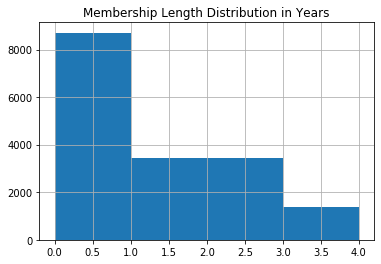

In [10]:
profile.mbr_shp_len.astype('timedelta64[Y]').hist(bins=4)
plt.title('Membership Length Distribution in Years')

Text(0.5, 1.0, 'Gender Distribution')

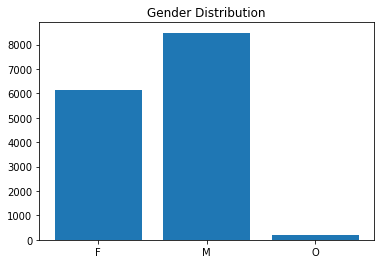

In [11]:
plt.bar(['F', 'M', 'O'],profile.groupby('gender').id.count())
plt.title('Gender Distribution')

Text(0.5, 1.0, '60+ yrs Old Other Income Distribution')

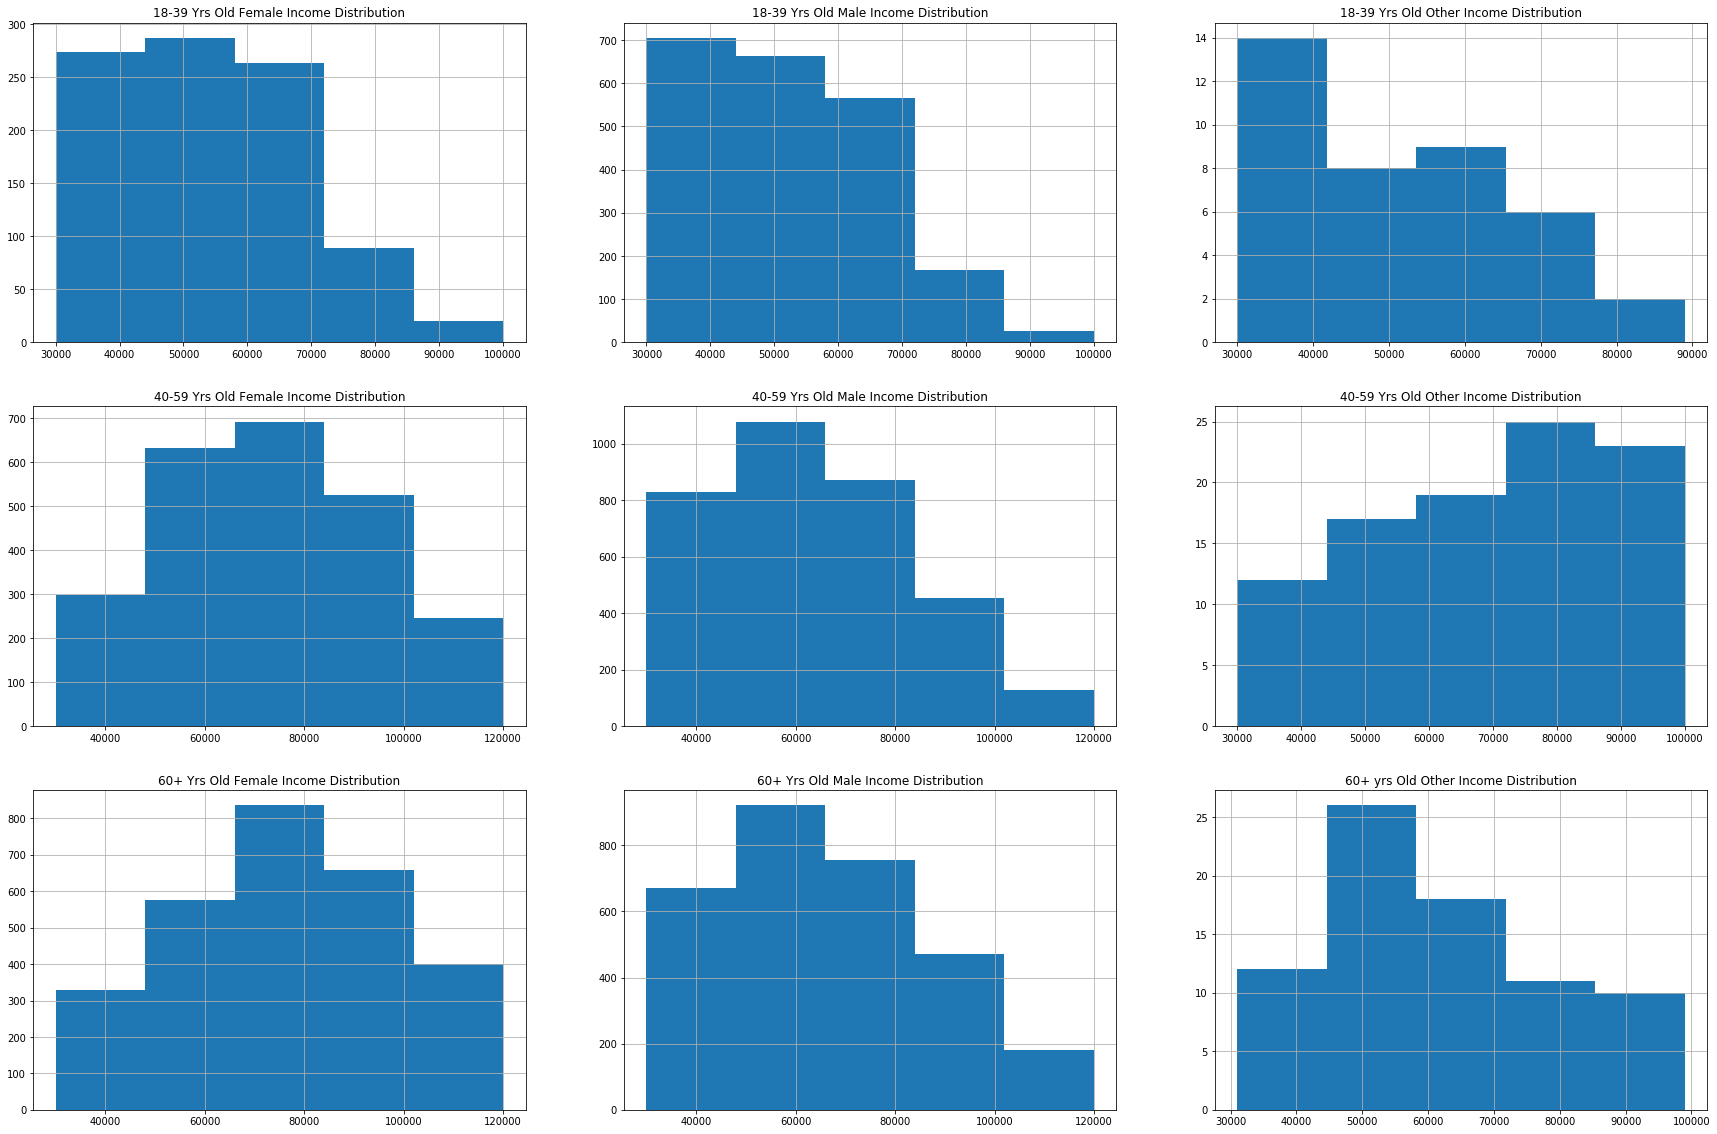

In [12]:
plt.figure(figsize=(30, 20))

plt.subplot(331)
profile[(profile.age>=18) & \
        (profile.age<40) & \
        (profile.gender=='F')].income.hist(bins=5)
plt.title('18-39 Yrs Old Female Income Distribution')

plt.subplot(332)
profile[(profile.age>=18) & \
        (profile.age<40) & \
        (profile.gender=='M')].income.hist(bins=5)
plt.title('18-39 Yrs Old Male Income Distribution')

plt.subplot(333)
profile[(profile.age>=18) & \
        (profile.age<40) & \
        (profile.gender=='O')].income.hist(bins=5)
plt.title('18-39 Yrs Old Other Income Distribution')

plt.subplot(334)
profile[(profile.age>=40) & \
        (profile.age<60) & \
        (profile.gender=='F')].income.hist(bins=5)
plt.title('40-59 Yrs Old Female Income Distribution')

plt.subplot(335)
profile[(profile.age>=40) & \
        (profile.age<60) & \
        (profile.gender=='M')].income.hist(bins=5)
plt.title('40-59 Yrs Old Male Income Distribution')

plt.subplot(336)
profile[(profile.age>=40) & \
        (profile.age<60) & \
        (profile.gender=='O')].income.hist(bins=5)
plt.title('40-59 Yrs Old Other Income Distribution')

plt.subplot(337)
profile[(profile.age>=60) & \
        (profile.age!=118) & \
        (profile.gender=='F')].income.hist(bins=5)
plt.title('60+ Yrs Old Female Income Distribution')

plt.subplot(338)
profile[(profile.age>=60) & \
        (profile.age!=118) & \
        (profile.gender=='M')].income.hist(bins=5)
plt.title('60+ Yrs Old Male Income Distribution')

plt.subplot(339)
profile[(profile.age>=60) & \
        (profile.age!=118) & \
        (profile.gender=='O')].income.hist(bins=5)
plt.title('60+ yrs Old Other Income Distribution')

### 3. Transcript

#### Basic Infos:

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
print(f'The shape of Transcript data is {transcript.shape}\n')
print(f'Null values statistics is: \n{transcript.isnull().sum()}\n')
print(f'There are {transcript.person.nunique()} unique ids.')

The shape of Transcript data is (306534, 4)

Null values statistics is: 
person    0
event     0
value     0
time      0
dtype: int64

There are 17000 unique ids.


#### Distributions

Text(0.5, 1.0, 'Event Distribution')

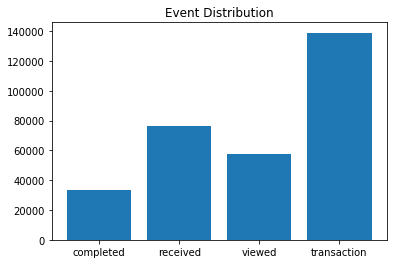

In [15]:
plt.bar(['completed', 'received', 'viewed', 'transaction'], 
        transcript.groupby('event').person.count())

plt.title('Event Distribution')

---

## Preprocessing

### 1. Merge `portfolio` and `transcript`

To find out the connection between transaction and offer, we need to combine the information in `portfolio` and `transcript`, and then create subsets of different offer-event combination for later feature engineering and modeling.

Before the merge, it's better to process the `value` column to extract offer ids.

In [16]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], 
                       axis=1)

transcript['clean_id'] = np.where(transcript['offer id'].isnull() & 
                                  transcript['offer_id'].notnull(), 
                                  transcript['offer_id'],
                                  transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

transcript = transcript.merge(portfolio,
                              how='left',
                              left_on='offer_id',
                              right_on='id')

Text(0.5, 1.0, 'Number of Offers in Transcripts by Type')

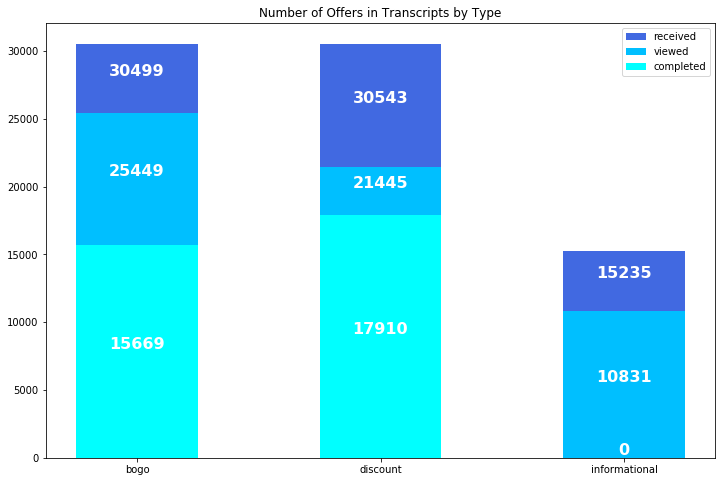

In [17]:
# plot merged dataset offer types 
offer_cnt = transcript.groupby(['event', 'offer_type'])['offer_type'].count()
complete_cnt = [offer_cnt[0], offer_cnt[1], 0]
receive_cnt = offer_cnt[2:5]
view_cnt = offer_cnt[5:]

x = ['bogo', 'discount', 'informational']

plt.figure(figsize=(12, 8))

ax1 = plt.bar(x, receive_cnt, width=0.5, color='royalblue',
              label='received', align='center')
ax2 = plt.bar(x, view_cnt, width=0.5, color='deepskyblue',
              label='viewed', align='center')
ax3 = plt.bar(x, complete_cnt, width=0.5, color='aqua',
              label='completed', align='center')

for r1, r2, r3 in zip(ax3, ax2, ax1):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    
    plt.text(r1.get_x() + r1.get_width() / 2., 
             h1 / 2., 
             "%d" % h1, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")
    
    plt.text(r2.get_x() + r2.get_width() / 2., 
             h1 + (h2 - h1) / 2., 
             "%d" % h2, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")
    
    plt.text(r3.get_x() + r3.get_width() / 2., 
             h2 + (h3 - h2) / 2., 
             "%d" % h3, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")

plt.legend(loc='upper right')
plt.title('Number of Offers in Transcripts by Type')

### 2. Subset by Categories

Typically, we have the following customer behaviours:

    1. make the transaction after receiving and viewing the offer

    2. viewing the offer and make no transaction

    3. make the transaction without receiving or viewing the offer

As for offer types, we can see from above that `offer_id` is not directly linked to `transaction` events, hence, we need to establish these links.

For `bogo` and `discount` offer, they have an obvious consequence of offer received, viewed, transaction and hence the offer completes.

However, for the `information` offer, there's no reward step for the easy links to transactions, we need a work around.

#### 2.1 `bogo` and `discount`

##### 2.1.1 Responsive Customers

Only the first kind of customers are regarded as responsive.

Before flagging any data, we need to reorganize the data first.

In [18]:
# drop the dummy columns created by `merge`
transcript_processed = transcript.drop(columns=['reward_x',
                                                'reward_y',
                                                'id',
                                                'value'],
                                       axis=1, inplace=False)

transcript_processed['email'] = 0
transcript_processed['mobile'] = 0
transcript_processed['social'] = 0
transcript_processed['web'] = 0

for i in range(transcript_processed.shape[0]):
    try:
        transcript_processed['email'].iloc[i] = \
                np.where(('email' in transcript_processed.channels.iloc[i]),
                         1, 0)
    
        transcript_processed['mobile'].iloc[i] = \
                np.where(('mobile' in transcript_processed.channels.iloc[i]),
                         1, 0)
    
        transcript_processed['social'].iloc[i] = \
                np.where(('social' in transcript_processed.channels.iloc[i]),
                         1, 0)
    
        transcript_processed['web'].iloc[i] = \
                np.where(('web' in transcript_processed.channels.iloc[i]),
                         1, 0)
    except:
        pass

transcript_processed.drop(columns=['channels'], axis=1, inplace=True)
transcript_processed['time'] = transcript_processed['time'] / 24
    
# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person',
                                                         'time']).reset_index()


In [19]:
transcript_processed.head(20)

,index,person,event,time,amount,offer_id,difficulty,duration,offer_type,email,mobile,social,web
0,55972,0009655768c64bdeb2e877511632db8f,offer received,7.00,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,1,1,1,0
1,77705,0009655768c64bdeb2e877511632db8f,offer viewed,8.00,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,1,1,1,0
2,89291,0009655768c64bdeb2e877511632db8f,transaction,9.50,22.16,NaN,NaN,NaN,NaN,0,0,0,0
3,113605,0009655768c64bdeb2e877511632db8f,offer received,14.00,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,1,1,0,1
4,139992,0009655768c64bdeb2e877511632db8f,offer viewed,15.50,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,1,1,0,1
5,153401,0009655768c64bdeb2e877511632db8f,offer received,17.00,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,1,1,1,1
6,168412,0009655768c64bdeb2e877511632db8f,transaction,17.25,8.57,NaN,NaN,NaN,NaN,0,0,0,0
7,168413,0009655768c64bdeb2e877511632db8f,offer completed,17.25,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,1,1,1,1
8,187554,0009655768c64bdeb2e877511632db8f,offer viewed,19.00,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,1,1,1,1
9,204340,0009655768c64bdeb2e877511632db8f,offer received,21.00,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,1,1,1,1


From above data, we can see that many `offer completed` events happened before the `offer viewed` event correspond to the same offer.

In [20]:
person_offer_cols = ['person', 'amount', 'offer_id', 'offer_type',
                     'difficulty', 'duration', 'email', 'mobile', 
                     'social', 'web', 'received', 'viewed',
                     'completed', 'transaction',
                     'receive_time', 'transaction_time']

unrelated_cols = ['person', 'amount', 'time']

person_offer = []

unrelated_transaction = []

In [21]:
received = False
viewed = False
completed = False
transaction = False

for i in range(transcript_processed.shape[0]):
    
    if viewed:
        viewed = False
        continue
    if completed:
        completed = False
        continue
    if transaction:
        transaction = False
        continue
    
    if transcript_processed.event.iloc[i] == 'offer received':
        received = True
        person = transcript_processed.person.iloc[i]
        ofr_id = transcript_processed.offer_id.iloc[i]
        start_time = transcript_processed.time.iloc[i]
        duration = transcript_processed.duration.iloc[i]

        if (transcript_processed.person.iloc[i+1] == person) and \
           (transcript_processed.offer_id.iloc[i+1] == ofr_id) and \
           (transcript_processed.event.iloc[i+1] == 'offer viewed'):
            viewed = True
            
            if (transcript_processed.person.iloc[i+2] == person) and \
               (transcript_processed.offer_id.iloc[i+2] == ofr_id) and \
               (transcript_processed.event.iloc[i+2] == 'offer completed'):
                completed = True
                
                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.event.iloc[i+3] == 'transaction'):
                    transaction = True
                    end_time = transcript_processed.time.iloc[i+3]
                    time_diff = end_time - start_time

                    if time_diff <= duration:
                        new_entry = [transcript_processed.person.iloc[i],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.offer_id.iloc[i],
                                     transcript_processed.offer_type.iloc[i],
                                     transcript_processed.difficulty.iloc[i],
                                     transcript_processed.duration.iloc[i],
                                     transcript_processed.email.iloc[i],
                                     transcript_processed.mobile.iloc[i],
                                     transcript_processed.social.iloc[i],
                                     transcript_processed.web.iloc[i],
                                     received, viewed,
                                     completed, transaction,
                                     start_time, end_time]

                        person_offer.append(new_entry)

                    elif time_diff > duration:
                        new_entry = [transcript_processed.person.iloc[i+3],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.time.iloc[i+3]]

                        unrelated_transaction.append(new_entry)

            elif (transcript_processed.person.iloc[i+2] == person) and \
                 (transcript_processed.event.iloc[i+2] == 'transaction'):
                transaction = True
                end_time = transcript_processed.time.iloc[i+2]

                if end_time - start_time <= duration:

                    if (transcript_processed.person.iloc[i+3] == person) and \
                       (transcript_processed.offer_id.iloc[i+3] == ofr_id) and \
                       (transcript_processed.event.iloc[i+3] == \
                        'offer completed'):
                        completed = True

                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif end_time - start_time > duration:
                    new_entry = [transcript_processed.person.iloc[i+2],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.time.iloc[i+2]]

                    unrelated_transaction.append(new_entry)

        elif (transcript_processed.person.iloc[i+1] == person) and \
             (transcript_processed.offer_id.iloc[i+1] == ofr_id) and \
             (transcript_processed.event.iloc[i+1] == 'offer completed'):
            completed = True

            if (transcript_processed.person.iloc[i+2] == person) and \
               (transcript_processed.offer_id.iloc[i+2] == ofr_id) and \
               (transcript_processed.event.iloc[i+2] == 'offer viewed'):
                viewed = True

                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.event.iloc[i+3] == 'transaction'):
                    transaction = True
                    end_time = transcript_processed.time.iloc[i+3]
                    time_diff = end_time - start_time

                    if time_diff <= duration:
                        new_entry = [transcript_processed.person.iloc[i],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.offer_id.iloc[i],
                                     transcript_processed.offer_type.iloc[i],
                                     transcript_processed.difficulty.iloc[i],
                                     transcript_processed.duration.iloc[i],
                                     transcript_processed.email.iloc[i],
                                     transcript_processed.mobile.iloc[i],
                                     transcript_processed.social.iloc[i],
                                     transcript_processed.web.iloc[i],
                                     received, viewed,
                                     completed, transaction,
                                     start_time, end_time]

                        person_offer.append(new_entry)

                    elif time_diff > duration:
                        new_entry = [transcript_processed.person.iloc[i+3],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.time.iloc[i+3]]

                        unrelated_transaction.append(new_entry)

            elif (transcript_processed.person.iloc[i+2] == person) and \
                 (transcript_processed.event.iloc[i+2] == 'transaction'):

                transaction = True
                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.offer_id.iloc[i+3] == ofr_id) and \
                   (transcript_processed.event.iloc[i+3] == 'offer viewed'):
                    viewed = True

                end_time = transcript_processed.time.iloc[i+3]
                time_diff = end_time - start_time

                if time_diff <= duration:
                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif time_diff > duration:
                    new_entry = [transcript_processed.person.iloc[i+2],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.time.iloc[i+2]]

                    unrelated_transaction.append(new_entry)

        elif (transcript_processed.person.iloc[i+1] == person) and \
             (transcript_processed.event.iloc[i+1] == 'transaction'):
            transaction = True
            end_time = transcript_processed.time.iloc[i+1]
            time_diff = end_time - start_time

            if (transcript_processed.person.iloc[i+2] == person) and \
               (transcript_processed.offer_id.iloc[i+2] == ofr_id) and \
               (transcript_processed.event.iloc[i+2] == 'offer viewed'):
                viewed = True

                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.event.iloc[i+3] == 'offer completed'):
                    completed = True

                if time_diff <= duration:
                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif time_diff > duration:
                    new_entry = [transcript_processed.person.iloc[i+1],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.time.iloc[i+1]]

                    unrelated_transaction.append(new_entry)

            elif (transcript_processed.person.iloc[i+2] == person) and \
                 (transcript_processed.event.iloc[i+2] == 'offer completed'):
                completed = True

                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.offer_id.iloc[i+3] == ofr_id) and \
                   (transcript_processed.event.iloc[i+3] == 'offer viewed'):
                    viewed = True

                end_time = transcript_processed.time.iloc[i+3]
                time_diff = end_time - start_time

                if time_diff <= duration:
                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif time_diff > duration:
                    new_entry = [transcript_processed.person.iloc[i+1],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.time.iloc[i+1]]

                    unrelated_transaction.append(new_entry)

    elif transcript_processed.event.iloc[i] == 'transaction':
        new_entry = [transcript_processed.person.iloc[i],
                     transcript_processed.amount.iloc[i],
                     transcript_processed.time.iloc[i]]

        unrelated_transaction.append(new_entry)


In [22]:
person_offer_df = pd.DataFrame(person_offer, columns=person_offer_cols)

unrelated_transaction_df = pd.DataFrame(unrelated_transaction,
                                        columns=unrelated_cols)

person_offer_df = person_offer_df.drop_duplicates()
unrelated_transaction_df = unrelated_transaction_df.drop_duplicates()

In [23]:
person_offer_df.head(20)

,person,amount,offer_id,offer_type,difficulty,duration,email,mobile,social,web,received,viewed,completed,transaction,receive_time,transaction_time
0,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0,1,1,1,0,True,True,False,True,7.0,9.50
1,0009655768c64bdeb2e877511632db8f,8.57,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,1,1,1,1,True,True,True,True,17.0,19.00
2,0009655768c64bdeb2e877511632db8f,14.11,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0,1,1,1,1,True,True,True,True,21.0,22.50
3,0009655768c64bdeb2e877511632db8f,10.27,2906b810c7d4411798c6938adc9daaa5,discount,10.0,7.0,1,1,0,1,True,False,True,True,24.0,27.50
4,0011e0d4e6b944f998e987f904e8c1e5,11.93,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,7.0,1,1,1,1,True,True,True,True,7.0,10.50
5,0011e0d4e6b944f998e987f904e8c1e5,22.05,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0,1,1,0,1,True,True,False,True,21.0,24.00
6,0020c2b971eb4e9188eac86d93036a77,17.63,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0,1,1,1,1,True,True,True,True,0.0,2.25
7,0020c2b971eb4e9188eac86d93036a77,17.24,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0,1,1,1,0,True,False,True,True,21.0,21.25
8,0020ccbbb6d84e358d3414a3ff76cffd,11.65,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,7.0,1,1,1,1,True,True,True,True,7.0,9.25
9,0020ccbbb6d84e358d3414a3ff76cffd,14.53,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,1,1,1,1,True,True,True,True,14.0,15.75


In [24]:
unrelated_transaction_df.head(20)

,person,amount,time
0,0009655768c64bdeb2e877511632db8f,13.56,23.00
1,0009655768c64bdeb2e877511632db8f,12.36,27.50
2,0009655768c64bdeb2e877511632db8f,28.16,28.75
3,0009655768c64bdeb2e877511632db8f,18.41,29.00
4,00116118485d4dfda04fdbaba9a87b5c,0.70,12.25
5,00116118485d4dfda04fdbaba9a87b5c,0.20,19.00
6,00116118485d4dfda04fdbaba9a87b5c,3.19,19.75
7,0011e0d4e6b944f998e987f904e8c1e5,13.49,5.50
8,0011e0d4e6b944f998e987f904e8c1e5,23.03,26.75
9,0011e0d4e6b944f998e987f904e8c1e5,8.96,27.25


## Feature engineering

In this session, let's add some new features based on given ones for later model building.

The `profile` dataset will be used in model building after adding the following features:

### New Feature Set 1

* transaction amount unrelated to offers

* transaction amount related to offers

* total transaction amount

* amount of profit in best offer related transactions (largest transaction after substracting offer reward)

* offer id of best offer

In [25]:
offer_profit = []

for i in range(person_offer_df.shape[0]):
    reward = portfolio[portfolio['id']==person_offer_df.offer_id.iloc[i]]['reward'].values[0]
    amt = person_offer_df.amount.iloc[i]
    offer_profit.append(amt - reward)

person_offer_df['offer_profit'] = offer_profit

In [26]:
unrelated_amt_df = pd.DataFrame({'id': unrelated_transaction_df.groupby('person').amount.sum().index, 
                                 'unrelated_amount': unrelated_transaction_df.groupby('person').amount.sum().values})

offer_amt_df = pd.DataFrame({'id': person_offer_df.groupby('person').amount.sum().index, 
                             'offer_amount': person_offer_df.groupby('person').amount.sum().values})

offer_profit_df = pd.DataFrame({'id': person_offer_df.groupby('person').offer_profit.sum().index, 
                                'total_profit': person_offer_df.groupby('person').offer_profit.sum().values})

clean_profile = profile.merge(unrelated_amt_df, how='left', on='id')
clean_profile = clean_profile.merge(offer_amt_df, how='left', on='id')
clean_profile = clean_profile.merge(offer_profit_df, how='left', on='id')

clean_profile = clean_profile[clean_profile['age']!=118].reset_index()

clean_profile.unrelated_amount = clean_profile.unrelated_amount.fillna(0.0)

clean_profile['total_amount'] = clean_profile['unrelated_amount'] + clean_profile['offer_amount']

In [27]:
best_profit_df = pd.DataFrame({'id': person_offer_df.groupby('person').offer_profit.max().index,
                               'best_profit': person_offer_df.groupby('person').offer_profit.max().values})

clean_profile = clean_profile.merge(best_profit_df, how='left', on='id')

best_offer_dict = {'id': person_offer_df.groupby('person').offer_profit.idxmax().index, 
                   'best_offer': person_offer_df.offer_id.iloc[
                       person_offer_df.groupby('person').offer_profit.idxmax().values]}

best_offer_df = pd.DataFrame(best_offer_dict)

clean_profile = clean_profile.merge(best_offer_df, how='left', on='id')

In [28]:
clean_profile.head()

,index,gender,age,id,became_member_on,income,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,376 days,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,443 days,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837
2,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26,91 days,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4
3,8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018-02-09,167 days,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017-11-11,257 days,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4


Buying coffee and light food is a kind of daily expanse, we can change the representation of income to weekly level. And calculating the total income since membership can also give us the ratio of coffee expense for each customer. 

Also, the ratio of actual transaction to the difficulty of the offer is also a good feature of ones coffee buying behaviour.

**NOTE:** for `informational` offers, they don't have a difficulty, so I took the ratio of `total_amount` to `unrelated_amount` instead.

### New Feature Set 2

* weekly income

* total income since joined membership

* ratio of offer related transaction amount in total amount

* ratio of total transaction amount in total income since joined membership

* mean ratio of transaction amount to offer difficulty

In [29]:
clean_profile['weekly_income'] = clean_profile['income'] / 52
clean_profile['income_since_mbrshp'] = clean_profile['weekly_income'] * clean_profile['mbr_shp_len'].astype('timedelta64[W]')
clean_profile.drop(columns=['income', 'became_member_on'], axis=1, inplace=True)

clean_profile['offer_amt_ratio'] = clean_profile.offer_amount / clean_profile.total_amount
clean_profile['coffee_expanse_ratio'] = clean_profile.total_amount / clean_profile.income_since_mbrshp

clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,376 days,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed,2153.846154,114153.846154,0.301519,0.000675
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,443 days,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837,1923.076923,121153.846154,0.384755,0.001315
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,91 days,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4,1346.153846,17500.000000,0.319072,0.003299
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,167 days,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9,1019.230769,23442.307692,1.000000,0.001554
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,257 days,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4,980.769231,35307.692308,0.487196,0.000442


In [30]:
person_info_df = person_offer_df[person_offer_df['offer_type']=='informational']
person_bogo_discnt_df = person_offer_df[person_offer_df['offer_type']!='informational']

In [31]:
person_bogo_discnt_df['ratio'] = person_bogo_discnt_df['amount'] / person_bogo_discnt_df['difficulty']
offer_ratio_df = pd.DataFrame({'id': person_bogo_discnt_df.groupby('person').ratio.mean().index, 
                               'mean_ratio': person_bogo_discnt_df.groupby('person').ratio.mean().values})

clean_profile = clean_profile.merge(offer_ratio_df, how='left', on='id')


clean_profile['only_info'] = np.where(np.isnan(clean_profile.mean_ratio), 1, 0)

for i in range(clean_profile.shape[0]):
    if np.isnan(clean_profile.mean_ratio.iloc[i]):
        clean_profile.mean_ratio.iloc[i] = clean_profile.total_amount.iloc[i] / clean_profile.unrelated_amount.iloc[i]

clean_profile.dropna()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,376 days,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed,2153.846154,114153.846154,0.301519,0.000675,1.431679,1
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,443 days,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837,1923.076923,121153.846154,0.384755,0.001315,4.161000,0
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,91 days,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4,1346.153846,17500.000000,0.319072,0.003299,1.842000,0
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,167 days,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9,1019.230769,23442.307692,1.000000,0.001554,2.053333,0
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,257 days,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4,980.769231,35307.692308,0.487196,0.000442,0.430214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,16992,F,21,400d0536e8794cbb855b0d882d67cbda,2017-09-17,312 days,10.54,6.77,-1.23,17.31,-0.54,2298d6c36e964ae4a3e7e9706d1fb8c2,1384.615385,60923.076923,0.391103,0.000284,0.606714,0
14820,16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,52 days,16.97,3.06,0.06,20.03,0.06,2298d6c36e964ae4a3e7e9706d1fb8c2,1038.461538,7269.230769,0.152771,0.002755,0.437143,0
14821,16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,13 days,17.09,6.46,1.46,23.55,1.46,9b98b8c7a33c4b65b9aebfe6a799e6d9,1384.615385,1384.615385,0.274310,0.017008,1.292000,0
14823,16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,871 days,156.58,33.09,8.09,189.67,6.03,9b98b8c7a33c4b65b9aebfe6a799e6d9,961.538462,119230.769231,0.174461,0.001591,1.470667,0


In [32]:
clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,376 days,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed,2153.846154,114153.846154,0.301519,0.000675,1.431679,1
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,443 days,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837,1923.076923,121153.846154,0.384755,0.001315,4.161000,0
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,91 days,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4,1346.153846,17500.000000,0.319072,0.003299,1.842000,0
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,167 days,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9,1019.230769,23442.307692,1.000000,0.001554,2.053333,0
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,257 days,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4,980.769231,35307.692308,0.487196,0.000442,0.430214,0


When building models, polynomials of given feature can also be beneficial to performance, but for now, we are not going to do so. My preference in feature engineering is natural and logical combinations of features instead of numerical manipulations.

### One More Thing

As mentioned in introduction, there are a group of customers who spend quite a few amount of money in Starbucks despite of any offer. So, from a commercial perspective, we don't want to send them any offer at all. Here, I assign `no_offer` as `best_offer` to customers of `offer_amt_ratio` lower than 15%.

In [33]:
clean_profile.sort_values(by=['unrelated_amount'], ascending=False, inplace=True)

clean_profile['no_offer'] = np.where((clean_profile['offer_amt_ratio']<=0.15), 1, 0)

clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info,no_offer
2391,2753,F,43,d240308de0ee4cf8bb6072816268582b,2017-06-30,391 days,1161.31,75.99,55.99,1237.30,18.22,ae264e3637204a6fb9bb56bc8210ddfd,1807.692308,99423.076923,0.061416,0.012445,2.483536,0,1
3379,3909,M,67,6406abad8e2c4b8584e4f68003de148d,2016-02-28,879 days,1158.26,53.50,36.50,1211.76,13.34,f19421c1d4aa40978ebb69ca19b0e20d,1519.230769,189903.846154,0.044151,0.006381,2.394667,0,1
11539,13211,M,55,52959f19113e4241a8cb3bef486c6412,2016-12-20,583 days,1155.58,113.30,83.30,1268.88,31.35,ae264e3637204a6fb9bb56bc8210ddfd,2134.615385,177173.076923,0.089291,0.007162,4.101500,0,1
14615,16752,M,58,946fc0d3ecc4492aa4cc06cf6b1492c3,2017-06-04,417 days,1107.14,125.26,108.26,1232.40,33.71,9b98b8c7a33c4b65b9aebfe6a799e6d9,1519.230769,89634.615385,0.101639,0.013749,4.088500,0,1
11658,13351,M,81,4d0ebb94a5a94fe6afd9350c7b1477e4,2016-01-16,922 days,1077.69,75.25,50.25,1152.94,30.18,0b1e1539f2cc45b7b9fa7c272da2e1d7,2250.000000,294750.000000,0.065268,0.003912,1.922000,0,1


## Building model
After pre-processing the data, the next step we'll start to implement models to figure out which factors affect most whether the customer will respond to the offer or not. And this project also attempts to predict whether the customer will respond to the different types of offers or not.

Therefore, we'll use the 'offer_responded' flag in the dataset to build models to predict if the customer will respond to the offer of not. Here we will choose the basic tree model as a baseline which will help explain the feature importance better so that we can get some insight into what factors affect customer's behavior most. Meanwhile, I'll also choose random forest as an alternate model to compare the baseline model is as an improvement over simple ensemble bagging of decision trees, in order to drive towards a high accuracy in training the model.

### Data Preparation

In [34]:
one_hot_gender_df = pd.get_dummies(clean_profile['gender'])

clean_profile = pd.concat([clean_profile, one_hot_gender_df], axis=1)
clean_profile = clean_profile[~np.isnan(clean_profile.offer_amount)]

clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,...,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info,no_offer,F,M,O
2391,2753,F,43,d240308de0ee4cf8bb6072816268582b,2017-06-30,391 days,1161.31,75.99,55.99,1237.30,...,1807.692308,99423.076923,0.061416,0.012445,2.483536,0,1,1,0,0
3379,3909,M,67,6406abad8e2c4b8584e4f68003de148d,2016-02-28,879 days,1158.26,53.50,36.50,1211.76,...,1519.230769,189903.846154,0.044151,0.006381,2.394667,0,1,0,1,0
11539,13211,M,55,52959f19113e4241a8cb3bef486c6412,2016-12-20,583 days,1155.58,113.30,83.30,1268.88,...,2134.615385,177173.076923,0.089291,0.007162,4.101500,0,1,0,1,0
14615,16752,M,58,946fc0d3ecc4492aa4cc06cf6b1492c3,2017-06-04,417 days,1107.14,125.26,108.26,1232.40,...,1519.230769,89634.615385,0.101639,0.013749,4.088500,0,1,0,1,0
11658,13351,M,81,4d0ebb94a5a94fe6afd9350c7b1477e4,2016-01-16,922 days,1077.69,75.25,50.25,1152.94,...,2250.000000,294750.000000,0.065268,0.003912,1.922000,0,1,0,1,0


In [35]:
y = pd.concat([pd.get_dummies(clean_profile['best_offer']), clean_profile['no_offer']], axis=1)

offer_dict = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
              '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_2',
              '3f207df678b143eea3cee63160fa8bed': 'info_1',
              '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_3',
              '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discnt_1',
              '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discnt_2',
              'fafdcd668e3743c1bb461111dcafc2a4': 'discnt_3',
              '5a8bc65990b245e5a138643cd4eb9837': 'info_2',
              'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_4',
              '2906b810c7d4411798c6938adc9daaa5': 'discnt_4'}

y.rename(columns=offer_dict, inplace=True)

cls_labels = list(y.columns.values)
y = y.to_numpy()

In [49]:
feat_list = ['age', 'mbr_shp_len', 'unrelated_amount', 'offer_amount', 'total_profit', 'total_amount', 'weekly_income', 'income_since_mbrshp', 'offer_amt_ratio', 'coffee_expanse_ratio', 'mean_ratio', 'F', 'M', 'O']

X = clean_profile[feat_list]
X['mbr_shp_len'] = X['mbr_shp_len'].astype('timedelta64[D]')

X = X.to_numpy()

X[np.isnan(X)] = 0.0
X[np.isinf(X)] = 0.0

X = normalize(X, norm='l1')

In [50]:
#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=36)

print(f'Training Features Shape: {X_train.shape}')
print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Features Shape: {X_test.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (9828, 14)
Training Labels Shape: (9828, 11)
Testing Features Shape: (4213, 14)
Testing Labels Shape: (4213, 11)


Text(0.5, 1.0, 'Number of Samples of each Class')

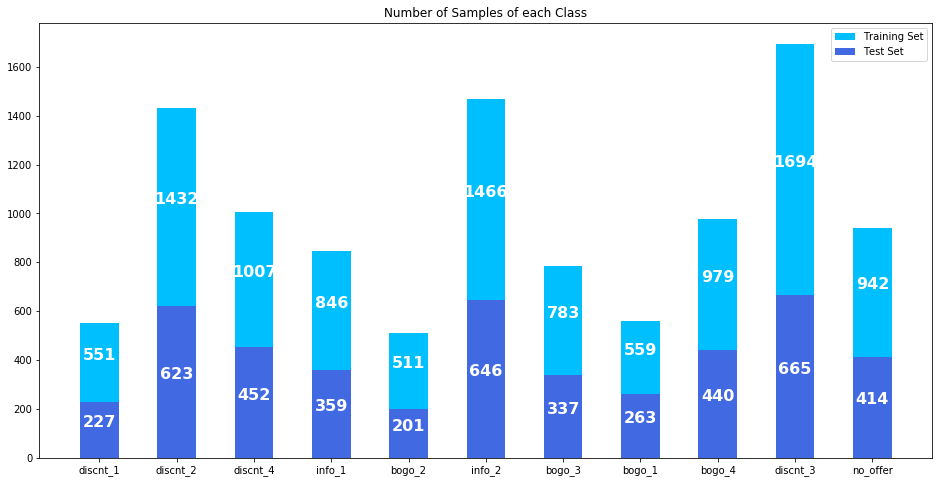

In [38]:
train_cnt = []
for j in range(11):
    train_cnt.append(y_train[:, j].sum())

test_cnt = []
for j in range(11):
    test_cnt.append(y_test[:, j].sum())

plt.figure(figsize=(16, 8))

ax1 = plt.bar(cls_labels, train_cnt, width=0.5, color='deepskyblue',
              label='Training Set', align='center')
ax2 = plt.bar(cls_labels, test_cnt, width=0.5, color='royalblue',
              label='Test Set', align='center')

for r1, r2 in zip(ax2, ax1):
    h1 = r1.get_height()
    h2 = r2.get_height()
    
    plt.text(r1.get_x() + r1.get_width() / 2., 
             h1 / 2., 
             "%d" % h1, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")
    
    plt.text(r2.get_x() + r2.get_width() / 2., 
             h1 + (h2 - h1) / 2., 
             "%d" % h2, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")

plt.legend(loc='upper right')
plt.title('Number of Samples of each Class')

### Helper Functions

In [39]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    
    model = model.fit(X_train, y_train)
    
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    print(classification_report(y_test, predictions_test, target_names=cls_labels))

### Performance Metrics

From plots in previous sessions, we can see that given data is imbalanced, the most popular offer has triple amount of samples comparing to the least popular one. This should be taken into consideration of metrics selection.

As we are training a model to predict best offer for given customer, finding the best offer significantly outweights avoiding the worst offer. So, while accuracy and F1 score are both very useful, we can lean a bit more on accuracy.

For starters, we will use `sklearn.metrics.classification_report`, later, we can still have some more exploration in metrics.


In [41]:
def grid_search_eval(y_true, y_pred):
    beta = 0.5
    sample_label_recall = []
    label_precision = []

    for i in range(y_true.shape[0]):
        if y_true[i].sum() != 0:
            sample_label_recall.append(np.bitwise_and(
                    y_pred[i], y_true[i]).sum() / y_true[i].sum())
        elif y_true[i].sum() == 0:
            sample_label_recall.append(1)

    for j in range(y_true.shape[1]):
        label_precision.append(np.invert(
                np.logical_xor(y_pred[:, j],
                               y_true[:, j])).sum() / y_true.shape[0])

    slr_mean = np.array(sample_label_recall).mean()
    lp_mean = np.array(label_precision).mean()
    f_score = (1 + beta**2) * slr_mean * lp_mean / (slr_mean + (beta**2) * lp_mean)

    return f_score

### Model Building

Here I chose to build a multi-output XGBoost model. The reason for multi-output classifier is the factor of 'no_offer' mentioned previously, in my opinion, adding it as another label rather than simply taking it as the 11th class makes more sense, as the manually assigned feature could be misleading for the model. 

In [51]:
xgb_clf = MultiOutputClassifier(
              XGBClassifier(colsample_bytree=1.0,
                            gamma=5.0,
                            learning_rate=0.5,
                            min_child_weight=1,
                            subsample=1.0))

train_predict(xgb_clf, X_train, y_train, X_test, y_test)

precision    recall  f1-score   support

    discnt_1       0.22      0.03      0.05       227
    discnt_2       0.36      0.01      0.02       623
    discnt_4       0.21      0.01      0.01       452
      info_1       0.42      0.04      0.07       359
      bogo_2       0.29      0.02      0.05       201
      info_2       0.53      0.15      0.23       646
      bogo_3       0.34      0.07      0.12       337
      bogo_1       0.39      0.06      0.11       263
      bogo_4       0.42      0.07      0.12       440
    discnt_3       0.35      0.05      0.09       665
    no_offer       0.96      0.92      0.94       414

   micro avg       0.63      0.13      0.22      4627
   macro avg       0.41      0.13      0.16      4627
weighted avg       0.42      0.13      0.17      4627
 samples avg       0.13      0.10      0.11      4627



As shown above, the accuracy of both models is good (more than 80%) for initial model implementation. But the F1 score is a bit lower than accuracy which may be tuned better in the later steps. From the result we can see that Decision Tree's F1 performs a little better than Random Forest, which means that decision tree is doing slightly better compared to random forest at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).

But the overall higher accuracy compared to F1 score indicates that the model is predicting the positive case (i.e. where an offer is responded) more accurately compared to predicting the negative cases (i.e. where an offer is not reponded), which is expected given the uneven classes.

### Model Tuning

The first thing we can do here is to run a grid search for the best combination of parameters.

For the XGBoost Classifier built above, we can tune the following parameters:

* `max_depth`: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

* `learning_rate`: the multiplier in weight update.

* `min_child_weight`: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

* `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.


In [42]:
gs_scorer = make_scorer(grid_search_eval)

In [55]:
xgb_params = {'estimator__max_depth'       : range(7, 16, 2),
              'estimator__learning_rate'   : [0.5, 0.75, 1.0],
              'estimator__min_child_weight': np.arange(2, 5, 1),
              'estimator__gamma'           : np.arange(3.5, 7.0, 0.5)}

xgb_gs = GridSearchCV(
                 MultiOutputClassifier(
                     XGBClassifier()),
                 param_grid=xgb_params,
                 scoring='f1_weighted',
                 n_jobs=16,
                 verbose=7
         )

In [53]:
xgb_gs.fit(X,y)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:  4.7min
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  8.3min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed: 12.5min


KeyboardInterrupt: 

In [122]:
xgb_gs.best_params_

{'estimator__gamma': 4.0,
 'estimator__learning_rate': 1.0,
 'estimator__max_depth': 15,
 'estimator__min_child_weight': 2}

As shown above in the comparison, after using tune parameters, the test accuracy slightly improved from 0.833 to 0.838 and the F1 score increase from 0.759 to 0.779.

In [123]:
best_xgb = MultiOutputClassifier(
               XGBClassifier(colsample_bytree=1.0,
                             gamma=4.0,
                             learning_rate=1.0,
                             max_depth=15,
                             min_child_weight=2,
                             subsample=1.0))

train_predict(best_xgb, X_train, y_train, X_test, y_test)

precision    recall  f1-score   support

    discnt_1       0.32      0.16      0.22       227
    discnt_2       0.27      0.14      0.18       623
    discnt_4       0.16      0.07      0.09       452
      info_1       0.25      0.13      0.17       359
      bogo_2       0.27      0.14      0.18       201
      info_2       0.37      0.23      0.28       646
      bogo_3       0.28      0.15      0.20       337
      bogo_1       0.36      0.16      0.22       263
      bogo_4       0.48      0.25      0.33       440
    discnt_3       0.31      0.22      0.26       665
    no_offer       1.00      1.00      1.00       414

   micro avg       0.42      0.25      0.31      4627
   macro avg       0.37      0.24      0.29      4627
weighted avg       0.37      0.25      0.29      4627
 samples avg       0.21      0.21      0.20      4627



## Conclusion

From the result of the project, it's likely to use machine learning model to predict whether the customer will respond to the offer or not, and the model also shows the main factors such as the length of membership, age, income which highly affect the possibility of customer's responding to the offer.

This project is trying to figure out:
- What factors mainly affect the usage of the offer from customer? Should the company send out the offer or not?

For this question, the feature importance given by three models shows that the length of the membership is the most important factor which affect how customer will make reponse to the offer. 

For all three models, the top three variables were pretty same - length of membership, income and age. However, income and age switched orders depending on offer type. And for BOGO offer, the count of offer received is the second important factor which decide if the customer will make the transaction.

- How possible will a customer open and use the offer sent to them? Is there any common characteristics on the customers who take the offer?

In this project, it uses thress separate models to predict if the customer will repond to the offer or not using 'offer_responded' trage variable and finally get the accuracy of 0.83, 0.87, 0.75 for BOGO, discount and informational offer seperatly. Although, the model performance of informational offer is slightly lower but is still acceptable in this phase of research. And for BOGO and discount models, the cost won't be too much to send out the offer even some people doesn't repond to it and it should be fine with this level of model performance.

## Next step

Due to time reasons, I couldn't get a chance to try some other enhancement in the step of model tuning. For example, probably, I can do some more experiment on feature engineering step to see if any other new features can improve the model, also I could also try to reduce some feature to see how it will affect the model performance.

Also, so far the analysis is focused more on customer's who successfully finish the transaction after they received the offer, there should be more insight for the other cases where the customer finishes the transactions regardless of the offer. If we could get any insight into those cases, maybe we can send out more offers to those customers.

In addition, I was thinking if I could do some unsupervised learning on clustering the customers based on information we are given, to see if there are any specific characteristics on a group of customers who will be more likely to respond to the offer.

In [ ]:
!jupyter nbconvert  Starbucks_Capstone_notebook.ipynb --to html